### Stage 1 - Dataset Preparation:

##### 1) Download the dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd
import torch

In [2]:
%pwd

'/Users/mukulagarwal/Desktop/Projects/transformers_/FineTuning'

In [3]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_Path = "sms_spam_classification"
data_file_path = Path(extracted_Path) / "SMSSpamCollection.tsv"

In [4]:
def download_and_unzip_spam_data(url,zip_path,extracted_path,data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and Extraction")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path,"wb") as out_file:
            out_file.write(response.read())
            
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
        
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path,data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [5]:
download_and_unzip_spam_data(url,zip_path,extracted_Path,data_file_path)

sms_spam_classification/SMSSpamCollection.tsv already exists. Skipping download and Extraction


In [6]:
import pandas as pd
df = pd.read_csv(data_file_path,sep = "\t",header = None, names = ['Label','Text'])

In [7]:
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


##### 2) Preprocess the dataset

In [22]:
## Here for simplicity we choose to undersample the dataset 
## to include 747 instances for each class to create a balanced
## dataset

In [8]:
def create_balanced_dataset(df):
    num_spam = df[df['Label']== "spam"].shape[0]
    ham_subset = df[df['Label'] == "ham"].sample(
        num_spam, random_state = 123
    )
    balanced_df = pd.concat([ham_subset,df[df['Label']=="spam"]],axis=0)
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [9]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [10]:
def random_split(df,train_frac,validation_frac):
    df = df.sample(frac=1,random_state=123).reset_index(drop = True)
    train_end = int(len(df) * train_frac)
    validation_end = int(train_end + len(df)*validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df,validation_df,test_df
    
train_df,validation_df,test_df = random_split(balanced_df,0.7,0.1)

In [11]:
train_df.to_csv("train.csv",index = None)  # type: ignore
validation_df.to_csv("validation.csv",index = None) # type: ignore
test_df.to_csv("test.csv",index = None) # type: ignore

In [12]:
## Checking token id for <|endoftext|>
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


##### 3) Creating DataLoaders

In [13]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self,csv_file,tokenizer,max_length = None,
                 pad_token = 50256):
        self.data = pd.read_csv(csv_file)
        
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
            
        self.encoded_texts = [
            encoded_text + (self.max_length - len(encoded_text))*[pad_token]
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        
        return (
            torch.tensor(encoded,dtype=torch.long),
            torch.tensor(label,dtype=torch.long)
        )
        
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length>max_length:
                max_length = encoded_length
        return max_length

In [17]:
%pwd
%cd ..

/Users/mukulagarwal/Desktop/Projects/transformers_


/opt/miniconda3/envs/torch/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [18]:
train_dataset = SpamDataset(
    csv_file="FineTuning/train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [19]:
val_dataset = SpamDataset(
    csv_file = "FineTuning/validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file = "FineTuning/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [20]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers=num_workers,
    drop_last = True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [21]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")


130 training batches
19 validation batches
38 test batches


### Stage 2: Model Setup

##### 1) Initialize the Model

In [22]:
from importlib.metadata import version
for pkg in ['torch','numpy','transformers']:
    print(f"Version - {pkg} is : {version(pkg)}")

Version - torch is : 2.5.1
Version - numpy is : 1.26.4
Version - transformers is : 4.47.0


In [23]:
%cd FineTuning/

/Users/mukulagarwal/Desktop/Projects/transformers_/FineTuning


/opt/miniconda3/envs/torch/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [24]:
from transformers import GPT2Model

model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL],cache_dir='checkpoints')
gpt_hf.eval()

/opt/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [25]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [26]:
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

In [27]:
import numpy as np

def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

In [32]:
%pwd
%cd ..

/Users/mukulagarwal/Desktop/Projects/transformers_


/opt/miniconda3/envs/torch/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [34]:
from making_LLM_from_scratch.Scripts.gpt_archietecture import GPTModel
gpt = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


#### Checking the model by doing next word prediction

In [37]:
input_prompt = "I am a disco dancer"
from making_LLM_from_scratch.Scripts.training_gpt import generate_simple_text,text_to_token_ids,token_ids_to_text

tokenizer = tiktoken.get_encoding("gpt2")
torch.manual_seed(123)

idx = generate_simple_text(
    model = gpt.to(device),
    idx = text_to_token_ids(input_prompt,
                            tokenizer=tokenizer).to(device),
    max_tokens = 30,
    content_size = BASE_CONFIG['context_length']
)

print(token_ids_to_text(idx,tokenizer=tokenizer))

I am a disco dancer, and I love to dance. I love to dance. I love to dance. I love to dance. I love to dance. I love to


##### Adding a Classification Head

In [38]:
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [39]:
for param in gpt.parameters():
    param.requires_grad = False
    
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(
    BASE_CONFIG['emb_dim'],
    num_classes
)

for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True
    
for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [40]:
input = "Do you have time"
input_tokens = torch.tensor(tokenizer.encode(input)).unsqueeze(0)
response = gpt(input_tokens)
pred_class_label = torch.argmax(torch.softmax(response[:,-1,:],dim=-1),dim=-1,keepdim=True).item()
pred_class_label

1

In [41]:
input_tokens

tensor([[5211,  345,  423,  640]])

#### Training Utilities

In [42]:
def calc_accuracy_loader(dataloader,model,device,num_batches=None):
    model.eval() 
    accuracy,total_datapoint = 0,0
    model = model.to(device)
    
    if num_batches==None:
         num_batches = len(dataloader)
         
    if num_batches<len(dataloader):
         num_batches = min(num_batches,len(dataloader))
         
    for i, (input_tokens,label) in enumerate(dataloader):
         if i < num_batches:  
               input_tokens = input_tokens.to(device)
               label = label.to(device)
               with torch.no_grad():
                    logits = model(input_tokens)
               probas = torch.softmax(logits[:,-1,:],dim=-1)
               pred_class_label = torch.argmax(probas,dim=-1,keepdim=True)
               accuracy_per_batch = torch.sum((pred_class_label.squeeze()==label).float()).item()
               
               accuracy += accuracy_per_batch
               total_datapoint += len(label)
         else:
              break
         
    model.train()
         
    return accuracy/total_datapoint
         

In [43]:
#x,y =next(iter(val_loader))
device = torch.device("cpu")
print(calc_accuracy_loader(train_loader,gpt,device,num_batches=10))
print(calc_accuracy_loader(val_loader,gpt,device,num_batches=10))
print(calc_accuracy_loader(test_loader,gpt,device,num_batches=10))

0.475
0.45
0.4875


In [44]:
def calc_loss_batch(input_tokens,label,model,device):
    
    input_tokens = input_tokens.to(device)
    label = label.to(device)
    
    logits = model(input_tokens)[:,-1,:]
    
    loss = torch.nn.functional.cross_entropy(logits,label)
    return loss
    

In [45]:
def calc_loss_loader(dataloader,model,device,num_batches):
    model.eval() 
    total_loss = 0
    model = model.to(device)
    
    if len(dataloader) == 0:
        return float("nan")
    
    if num_batches==None:
         num_batches = len(dataloader)
         
    if num_batches<len(dataloader):
         num_batches = min(num_batches,len(dataloader))
          
    for i , (input_tokens,label) in enumerate(dataloader):
        if i<num_batches:
            loss= calc_loss_batch(input_tokens,label,model,device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [46]:
calc_loss_loader(test_loader,gpt,device,5)

2.3219622373580933

In [47]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
        
    model.train()
    return train_loss,val_loss

##### Training Function

In [48]:
def train_spam_classifier(model,train_dataloader,val_dataloader,num_epochs,optimizer,
                          device,eval_freq,eval_iter):
    
    train_losses,validation_losses,track_samples_seen = [],[],[]
    train_acccuracies, val_accuracies = [],[]
    samples_seen,global_step = 0,-1
    
    for epoch in range(num_epochs):
        model.train()
        for j, (input_tokens,label) in enumerate(train_dataloader):
            optimizer.zero_grad()
            loss = calc_loss_batch(input_tokens,label,model,device)
            loss.backward()
            optimizer.step()
            
            samples_seen += len(label)
            track_samples_seen.append(samples_seen)
            global_step += 1
            
            if global_step%eval_freq==0:
                train_loss,val_loss = evaluate_model(model,train_dataloader,val_dataloader,
                                                     device,eval_iter)
                train_losses.append(train_loss)
                validation_losses.append(val_loss)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                 f"Train loss {train_loss:.3f}, "
                 f"Val loss {val_loss:.3f}")
                
        train_accu = calc_accuracy_loader(train_dataloader,model,device)
        val_accu = calc_accuracy_loader(val_dataloader,model,device)
        
        train_acccuracies.append(train_accu)
        val_accuracies.append(val_accu)
        
    return train_losses,validation_losses,train_acccuracies,val_accuracies,track_samples_seen

#### Model Training and Evaluation

In [49]:
torch.manual_seed(123)
device = torch.device("cpu")

from torch.optim import AdamW
optimizer = AdamW(gpt.parameters(),lr = 1e-5,weight_decay=0.1)

train_losses,validation_losses,train_acccuracies,val_accuracies,track_samples_seen = train_spam_classifier(
    gpt,train_loader,val_loader,5,optimizer,device,50,5
)

Ep 1 (Step 000000): Train loss 3.034, Val loss 2.545
Ep 1 (Step 000050): Train loss 0.917, Val loss 0.824
Ep 1 (Step 000100): Train loss 0.669, Val loss 0.701
Ep 2 (Step 000150): Train loss 0.656, Val loss 0.662
Ep 2 (Step 000200): Train loss 0.626, Val loss 0.641
Ep 2 (Step 000250): Train loss 0.663, Val loss 0.630
Ep 3 (Step 000300): Train loss 0.622, Val loss 0.599
Ep 3 (Step 000350): Train loss 0.571, Val loss 0.571
Ep 4 (Step 000400): Train loss 0.552, Val loss 0.551
Ep 4 (Step 000450): Train loss 0.551, Val loss 0.531
Ep 4 (Step 000500): Train loss 0.531, Val loss 0.510
Ep 5 (Step 000550): Train loss 0.543, Val loss 0.503
Ep 5 (Step 000600): Train loss 0.496, Val loss 0.470


In [50]:
%cd FineTuning

/Users/mukulagarwal/Desktop/Projects/transformers_/FineTuning


/opt/miniconda3/envs/torch/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen,train_losses, val_losses,figure_name):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(figure_name)
    plt.show()

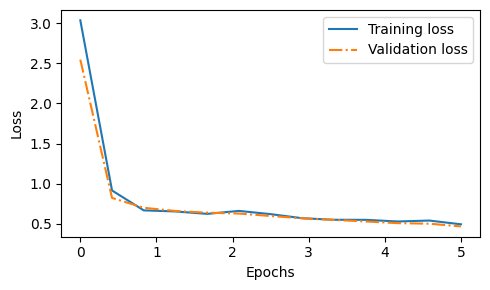

In [54]:
epochs_tensor = torch.linspace(0, 5, len(train_losses))
plot_losses(epochs_tensor, train_losses, validation_losses,"gpt-small-fintuned.png")

In [55]:
def classify_review(text,model,tokenizer,max_length = None,pad_token_id = 50256):
    
    input_tokens = tokenizer.encode(text)
    sup_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_tokens[:min(max_length,sup_context_length)]
    
    input_ids += [pad_token_id]*(max_length-len(input_ids))
    input_ids = torch.tensor(input_ids,device=device).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(input_ids)[:,-1,:]
        
    predicted_labels = torch.argmax(logits,dim=-1,keepdim=True).item()
    return "spam" if predicted_labels == 1 else "not spam"
    
    

In [56]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(
    classify_review(text_2,gpt,tokenizer,max_length=train_dataset.max_length)
)

not spam


In [57]:
torch.save(gpt.state_dict(), "review_classifier.pth")

##### Loading saved GPT-small FineTunes model

In [58]:
GPT_CONFIG_124M = {
        "vocab_size": 50257,     # Vocabulary size
        "context_length": 1024,  # Context length
        "emb_dim": 768,          # Embedding dimension
        "n_heads": 12,           # Number of attention heads
        "n_layers": 12,          # Number of layers
        "drop_rate": 0.1,        # Dropout rate
        "qkv_bias": True         # Query-key-value bias
    }

In [59]:
import torch
device = torch.device("cpu")
model = GPTModel(GPT_CONFIG_124M)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=GPT_CONFIG_124M["emb_dim"], out_features=num_classes)

model_path = "/Users/mukulagarwal/Desktop/Projects/transformers_/FineTuning/review_classifier.pth"

# Then load model weights
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [60]:
print(calc_accuracy_loader(train_loader,model,device))
print(calc_accuracy_loader(val_loader,model,device))
print(calc_accuracy_loader(test_loader,model,device))

0.8298076923076924
0.8456375838926175
0.84


##### LORA Finetuning

In [81]:
import math
class LoRALayer(torch.nn.Module):
    def __init__(self,in_dim,out_dim,rank,alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim,rank))
        torch.nn.init.kaiming_uniform_(self.A,a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank,out_dim))
        self.alpha = alpha
        
    def forward(self,X):
        x = self.alpha * (X @ self.A @ self.B) 
        return x

In [82]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self,linear,rank,alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features,linear.out_features,rank,alpha)
        
    def forward(self,x):
        return self.linear(x) + self.lora(x)

In [83]:
def replace_linear_with_lora(model,rank,alpha):
    for name,module in model.named_children():
        if isinstance(module,torch.nn.Linear):
            setattr(model,name,LinearWithLoRA(module,rank,alpha))
        else:
            replace_linear_with_lora(module,rank,alpha)

In [84]:
from making_LLM_from_scratch.Scripts.gpt_archietecture import GPTModel
gpt = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)

for param in gpt.parameters():
    param.requires_grad = False
    
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(
    BASE_CONFIG['emb_dim'],
    num_classes
)

for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True
    
for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [85]:
total_model_parameter = sum(p.numel() for p in gpt.parameters() if p.requires_grad == True)
print("Total Model Parameters: ",total_model_parameter)

Total Model Parameters:  7090946


In [86]:
for param in gpt.parameters():
    param.requires_grad = False
    
total_model_parameter = sum(p.numel() for p in gpt.parameters() if p.requires_grad == True)
print("Total Model Parameters After: ",total_model_parameter)

Total Model Parameters After:  0


In [87]:
replace_linear_with_lora(gpt,rank=16,alpha=16)
total_model_parameter = sum(p.numel() for p in gpt.parameters() if p.requires_grad == True)
print("Total Trainable Parameters: ",total_model_parameter)

Total Trainable Parameters:  2666528


In [88]:
devive = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [89]:
#x,y =next(iter(val_loader))
device = torch.device("cpu")
print(calc_accuracy_loader(train_loader,gpt,device,num_batches=10))
print(calc_accuracy_loader(val_loader,gpt,device,num_batches=10))
print(calc_accuracy_loader(test_loader,gpt,device,num_batches=10))

0.475
0.45
0.4875


In [90]:
import time
torch.manual_seed(123)
device = torch.device("cpu")

from torch.optim import AdamW
optimizer = AdamW(gpt.parameters(),lr = 1e-5,weight_decay=0.1)
start_time = time.time()

train_losses,validation_losses,train_acccuracies,val_accuracies,track_samples_seen = train_spam_classifier(
    gpt,train_loader,val_loader,5,optimizer,device,50,5
)

end_time = time.time()

print("total_time: ", {round((end_time-start_time)/60,2)})

Ep 1 (Step 000000): Train loss 0.955, Val loss 0.832
Ep 1 (Step 000050): Train loss 0.433, Val loss 0.382
Ep 1 (Step 000100): Train loss 0.411, Val loss 0.313
Ep 2 (Step 000150): Train loss 0.445, Val loss 0.336
Ep 2 (Step 000200): Train loss 0.307, Val loss 0.215
Ep 2 (Step 000250): Train loss 0.538, Val loss 0.658
Ep 3 (Step 000300): Train loss 0.341, Val loss 0.540
Ep 3 (Step 000350): Train loss 0.160, Val loss 0.055
Ep 4 (Step 000400): Train loss 0.133, Val loss 0.045
Ep 4 (Step 000450): Train loss 0.142, Val loss 0.035
Ep 4 (Step 000500): Train loss 0.079, Val loss 0.195
Ep 5 (Step 000550): Train loss 0.061, Val loss 0.086
Ep 5 (Step 000600): Train loss 0.058, Val loss 0.212
total_time:  {24.12}


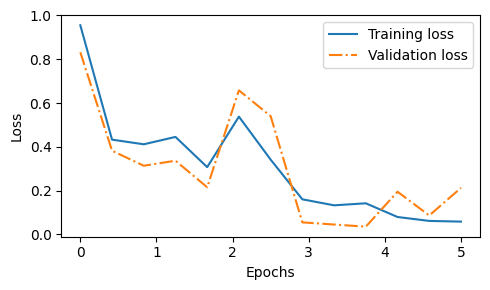

In [91]:
epochs_tensor = torch.linspace(0, 5, len(train_losses))
plot_losses(epochs_tensor, train_losses, validation_losses,'lora-finedtuned-gpt-small.png')

In [92]:
print(calc_accuracy_loader(train_loader,gpt,device,num_batches=10))
print(calc_accuracy_loader(val_loader,gpt,device,num_batches=10))
print(calc_accuracy_loader(test_loader,gpt,device,num_batches=10))

0.9625
0.975
0.975


In [93]:
%cd FineTuning
torch.save(gpt.state_dict(),"lora_spam_classifier.pth")

/opt/miniconda3/envs/torch/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


[Errno 2] No such file or directory: 'FineTuning'
/Users/mukulagarwal/Desktop/Projects/transformers_/FineTuning


### DistillBert

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer 
import numpy as np

In [3]:
import torch
import pandas as pd
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
    )

model.out_head = torch.nn.Linear(in_features=768, out_features=2)
for param in model.parameters():
    param.requires_grad = False
    
for param in model.pre_classifier.parameters():
    param.requires_grad = True
for param in model.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")

X_train = list(train_df['Text'])
y_train = list(train_df['Label'])

X_val = list(val_df['Text'])
y_val = list(val_df['Label'])

X_train_tokenized = tokenizer(X_train,truncation=True,max_length=256,padding=True)
X_val_tokenized = tokenizer(X_val,truncation=True,max_length=256,padding=True)

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [8]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [9]:
train_dataset[5]

{'input_ids': tensor([  101,  2572,  2006,  1037,  3345,  2067,  2013, 15944,  2061,  1045,
          1005,  1049,  4452,  2025,   999,  1045,  1005,  1049,  6595,  3712,
          6455,  2125,  2651,  7570,  7570,   999,  2097,  2022,  2105,  9317,
          2295,  1012,  2079,  2017, 11281,  1996,  4038,  2252,  2023,  2733,
          2011,  1996,  2126,  1029,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [10]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    return {"accuracy":accuracy}

In [12]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    output_dir="distillbert-output",
    num_train_epochs=5,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [13]:
trainer.train()

  0%|          | 0/655 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 76%|███████▋  | 500/655 [01:15<00:21,  7.20it/s]

{'loss': 0.0828, 'grad_norm': 0.015849823132157326, 'learning_rate': 1.1832061068702292e-05, 'epoch': 3.82}


100%|██████████| 655/655 [01:37<00:00,  6.74it/s]

{'train_runtime': 97.2673, 'train_samples_per_second': 53.718, 'train_steps_per_second': 6.734, 'train_loss': 0.06800387324267672, 'epoch': 5.0}


TrainOutput(global_step=655, training_loss=0.06800387324267672, metrics={'train_runtime': 97.2673, 'train_samples_per_second': 53.718, 'train_steps_per_second': 6.734, 'total_flos': 168986046075000.0, 'train_loss': 0.06800387324267672, 'epoch': 5.0})

In [16]:
trainer.evaluate()

38it [00:37,  1.01it/s]                        

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.030464831739664078,
 'eval_accuracy': 0.9865771812080537,
 'eval_runtime': 1.33,
 'eval_samples_per_second': 112.031,
 'eval_steps_per_second': 14.286,
 'epoch': 5.0}

In [18]:
trainer.save_model("distillbert-model-fined-tuned")

Loading Pretrained Distill-Bert Model and testing it

In [28]:
model_2 = AutoModelForSequenceClassification.from_pretrained("distillbert-model-fined-tuned")
text = ["I Love you baby, will meet you tommorow at the cafe","You have won a lottery. Click on this link and fill the form to claim your prize"]
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt')
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions

Some weights of the model checkpoint at distillbert-model-fined-tuned were not used when initializing DistilBertForSequenceClassification: ['out_head.bias', 'out_head.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


array([[9.9867541e-01, 1.3246136e-03],
       [8.5922057e-04, 9.9914074e-01]], dtype=float32)